#### Manual annotation of Xenium add-on panel healthy gut data 
- **Developed by:** Anna Maguza
- **Affilation:** Wuerzburg Institute for System Immunology
- **Created date:** 2nd August 2024
- **Last modified date:** 5th August 2024

##### Import packages

In [42]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
import seaborn as sns

##### Setup working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [3]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'
torch.set_float32_matmul_precision('medium')

Global seed set to 1712


In [4]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 3,
)

In [5]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in data

In [6]:
adata = sc.read_h5ad('/../../../gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_cell_states.h5ad')

In [7]:
X_is_raw(adata)

True

#### Run scVI

In [8]:
adata.layers['counts'] = adata.X.copy()

In [9]:
scvi.model.SCVI.setup_anndata(adata,
                              layer = 'counts')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [10]:
scvi_model = scvi.model.SCVI(adata,
                            n_latent = 50, 
                            n_layers = 3, 
                            dispersion = 'gene-batch', 
                            gene_likelihood = 'nb')

In [11]:
scvi_model.train(100, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 100/100: 100%|███████████████████| 100/100 [17:27<00:00, 10.13s/it, v_num=1, train_loss_step=112, train_loss_epoch=124]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|███████████████████| 100/100 [17:27<00:00, 10.47s/it, v_num=1, train_loss_step=112, train_loss_epoch=124]


In [12]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

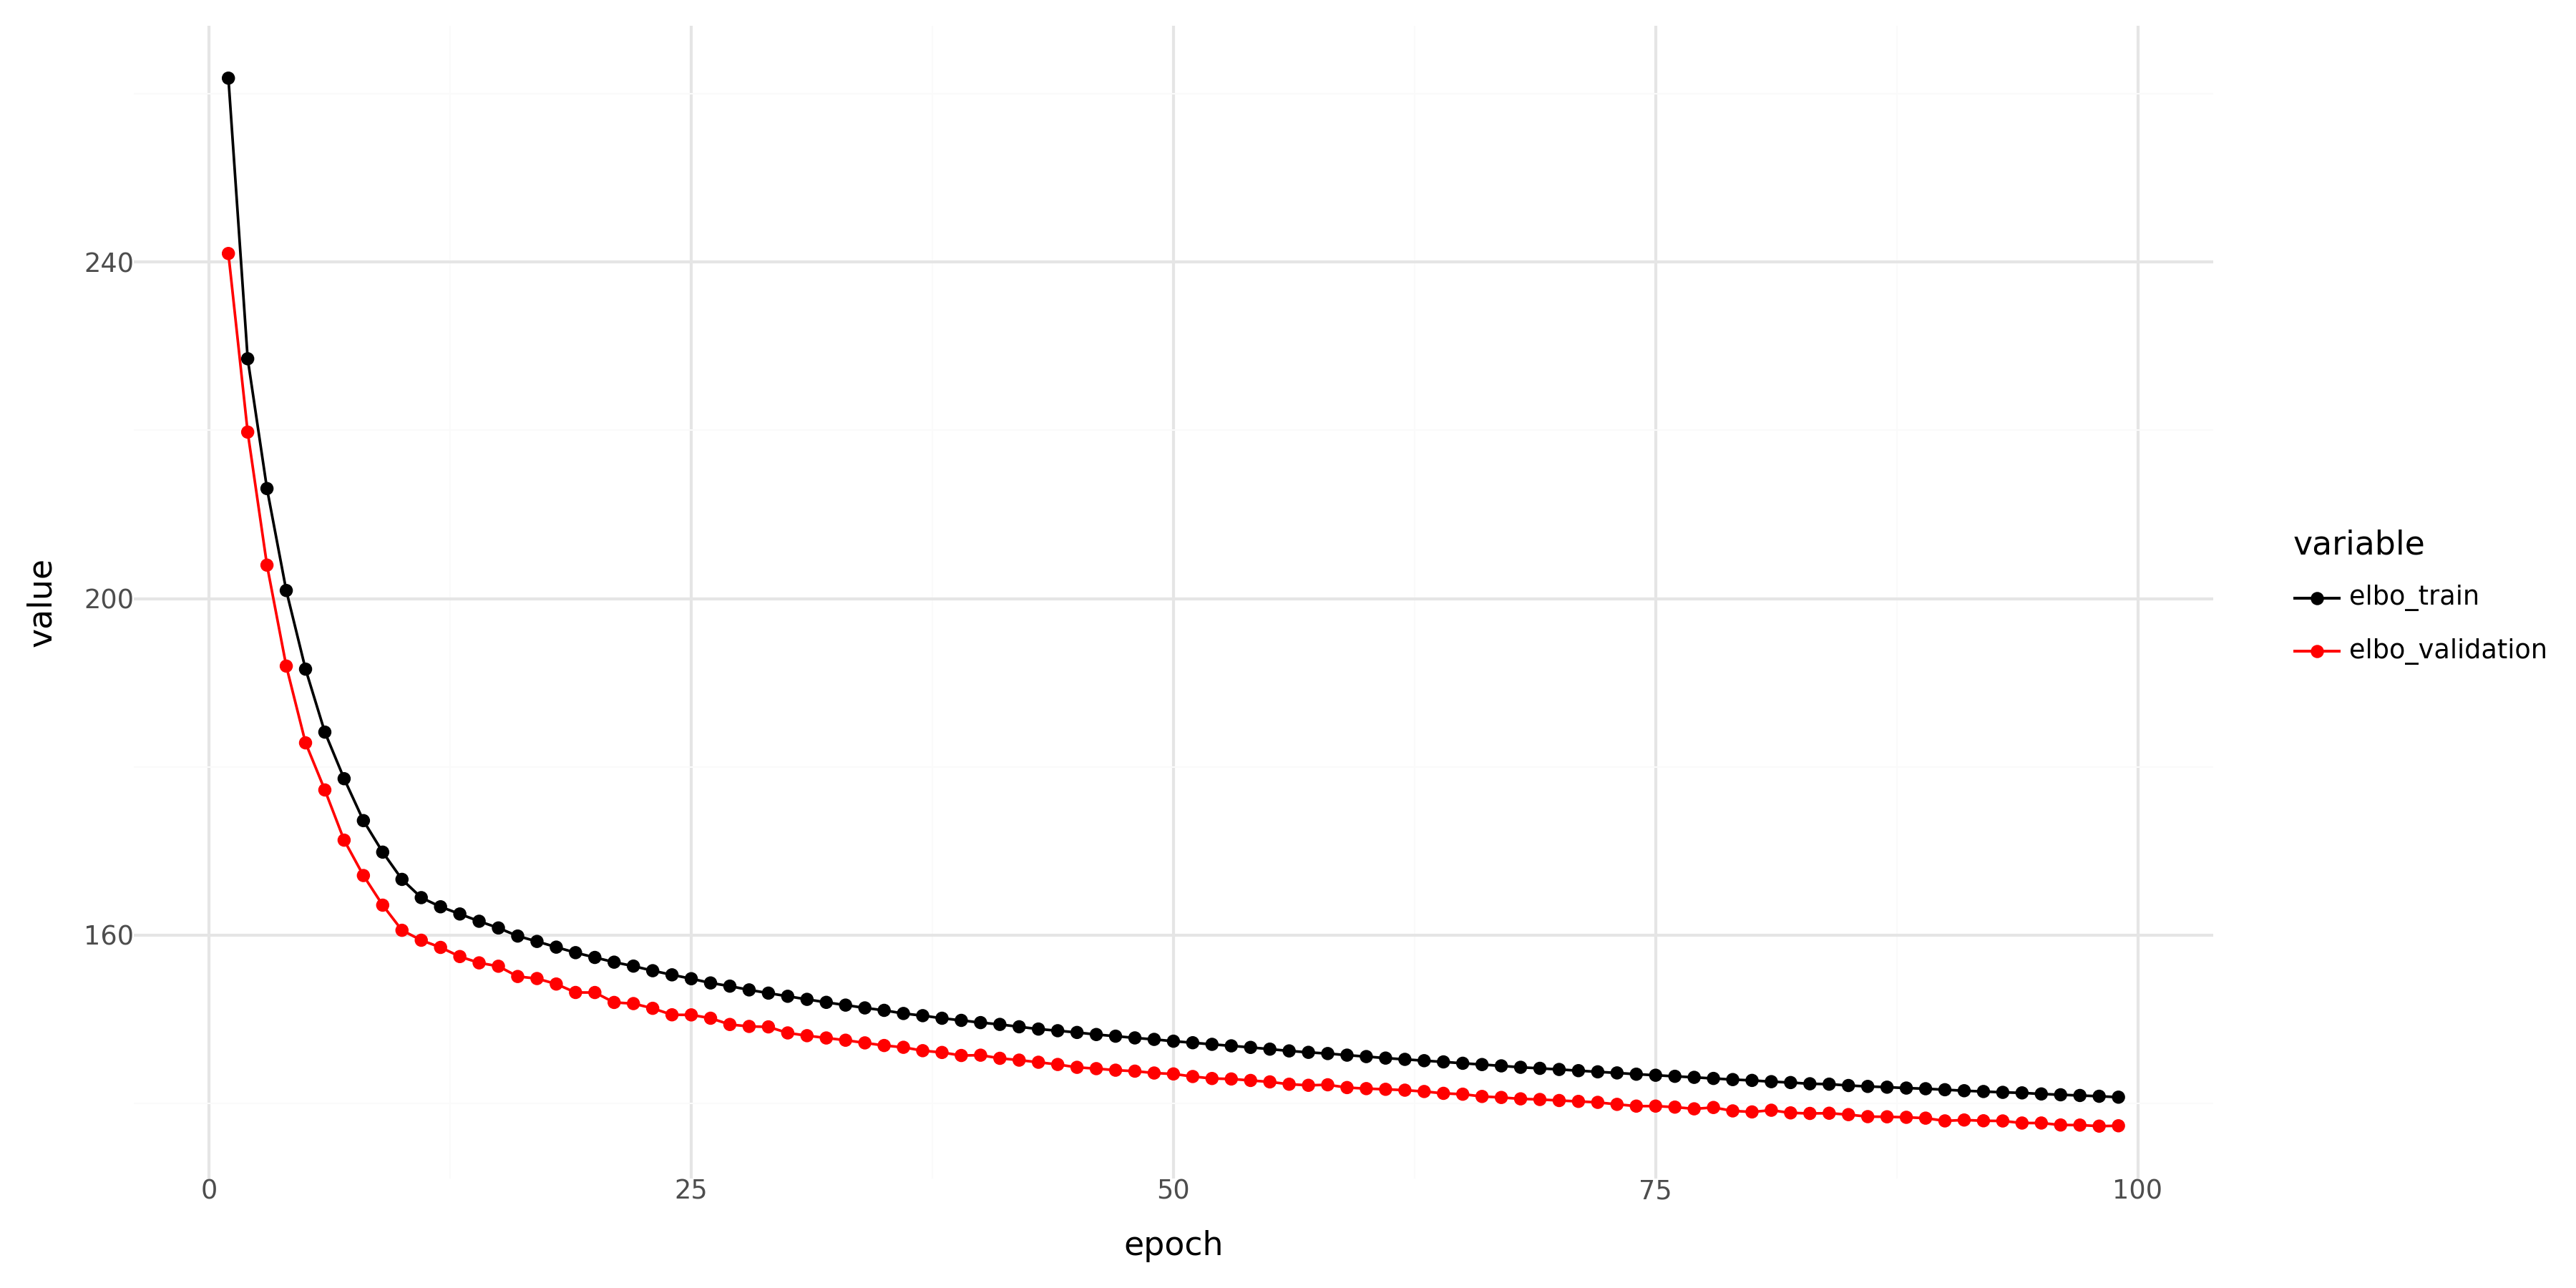

In [13]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

+ Visualize dataset

In [14]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.2, spread = 2, random_state = 1712)

computing neighbors


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:27)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:30)


In [15]:
adata.obs

,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,...,pct_counts_in_top_50_genes,pct_counts_in_top_150_genes,n_counts,Cell_Type,Stem_cells,CellType2,C_scANVI,Predicted_cell_states,_scvi_batch,_scvi_labels
cell_id,,,,,,,,,,,,,,,,,,,,,
aaaagkoa-1,830.147217,836.563416,284,0,0,0,0,284.0,653.365805,23.120001,...,96.830986,100.0,284.0,Mesenchymal,Unknown,Mesenchymal,Fibroblasts,Transitional Stromal 3 (C3+),0,0
aaablbol-1,735.468018,854.389282,116,0,0,0,0,116.0,651.243461,12.643750,...,100.000000,100.0,116.0,Mesenchymal,Unknown,Mesenchymal,Fibroblasts,Transitional Stromal 3 (C3+),0,0
aaabogma-1,847.423462,846.633240,170,0,0,0,0,170.0,674.544087,18.152813,...,100.000000,100.0,170.0,Mesenchymal,Unknown,Mesenchymal,Fibroblasts,Transitional Stromal 3 (C3+),0,0
aaabpdim-1,1543.696045,4223.798340,61,0,0,0,0,61.0,172.406569,11.379375,...,100.000000,100.0,61.0,Mesenchymal,Unknown,Mesenchymal,Myofibroblasts,Myofibroblasts GREM1 GREM2,0,0
aaabpfoj-1,1551.099121,4220.062988,105,0,0,0,0,105.0,283.490948,56.806565,...,100.000000,100.0,105.0,Mesenchymal,Unknown,Mesenchymal,Myofibroblasts,Myofibroblasts GREM1 GREM2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oikabfkp-1,8284.036133,3061.574951,219,0,0,0,0,219.0,70.308284,38.563439,...,100.000000,100.0,219.0,Epithelial,Unknown,Epithelial,Colonocyte,Enterocytes TMIGD1 MEP1A,0,0
oikalpjm-1,8267.514648,3067.372314,173,0,0,0,0,173.0,45.743283,11.334219,...,100.000000,100.0,173.0,Epithelial,Unknown,Epithelial,Colonocyte,Enterocytes TMIGD1 MEP1A,0,0
oikamhom-1,8260.333984,3068.529053,369,0,0,0,0,369.0,104.040004,46.691564,...,95.663957,100.0,369.0,Epithelial,Unknown,Epithelial,Colonocyte,Enterocytes TMIGD1 MEP1A,0,0


In [ ]:
sc.set_figure_params(dpi = 300, figsize=(10,7))
sc.pl.umap(adata, color = ['CellType2', 'C_scANVI', 'Predicted_cell_states'], ncols = 2, frameon = False, size = 1)

In [17]:
adata.write_h5ad('/../../../gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_cell_states.h5ad')

### Check the markers expression

In [19]:
adata_log = adata.copy()
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ABCA8', 'ABCC8', 'ACACB', 'ACKR1', 'ACTA2', 'ADAM28', 'ADH1C', 'ADRA2A', 'AFAP1L2', 'AGTR1', 'AKR1C3', 'AKR7A3', 'ALDH1B1', 'ANK2', 'ANO7', 'ANPEP', 'ANXA1', 'ANXA13', 'APOB', 'APOE', 'AQP1', 'AQP8', 'AREG', 'ARHGAP24', 'ARX', 'ASCL2', 'ATOH1', 'AVIL', 'AZGP1', 'B3GNT6', 'BANK1', 'BATF', 'BCAS1', 'BEST2', 'BEST4', 'BMP4', 'BMP5', 'BMX', 'BRCA2', 'C1QA', 'C1QB', 'C1QBP', 'C1QC', 'C2orf88', 'C7', 'CA1', 'CA2', 'CA4', 'CA7', 'CADM2', 'CADPS', 'CALB2', 'CCDC80', 'CCL11', 'CCL13', 'CCL20', 'CCL4', 'CCL5', 'CCR7', 'CD14', 'CD163', 'CD177', 'CD2', 'CD24', 'CD36', 'CD3D', 'CD3E', 'CD3G', 'CD40LG', 'CD5', 'CD6', 'CD7', 'CD79A', 'CD79B', 'CD83', 'CD8A', 'CD8B', 'CDCA7', 'CDH1', 'CDH19', 'CDHR5', 'CDK15', 'CDK6', 'CDKN2B', 'CEACAM1', 'CEACAM5', 'CEACAM6', 'CEACAM7', 'CEP126', 'CES1', 'CES2', 'CFTR', 'CHGA', 'CHGB', 'CHI3L2', 'CHP2', 'CHRM3', 'CKAP4', 'CLCA1', 'CLCA4', 'CL

### Annotate manually

In [20]:
fig_dir = '/../../../gut_project/Processed_data/Gut_data/10X_Xenium_data/Manual_annotation/figures/'

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(15, 10))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'Predicted_cell_states'], ncols = 2, frameon = False, size = 1, show=False)
    plt.savefig(f"{fig_dir}/umap_predicted_annotations.png", bbox_inches="tight")

#### Epithelial cells

+ Stem cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'LGR5', 'OLFM4', 'ASCL2', 'RGMB'], ncols = 2, frameon = False, size = 1, cmap='magma_r', show = False)
    plt.savefig(f"{fig_dir}/stem.png", bbox_inches="tight")

+ TA cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'MKI67', 'UBE2C', 'TOP2A'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/TA.png", bbox_inches="tight")

+ EEC cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'CHGA', 'NEUROD1'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/EECs.png", bbox_inches="tight")

+ Goblet

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'SPDEF', 'WFDC2'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Goblet.png", bbox_inches="tight")

+ Tuft

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'LRMP', 'TRPM5'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Tuft.png", bbox_inches="tight")

+ Enterocytes

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CellType2', 'C_scANVI', 'FABP2', 'CEACAM1', 'EPCAM', 'ANPEP'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Enterocytes.png", bbox_inches="tight")

+ Colonocytes

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CA2', 'SLC26A2', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Colonocytes.png", bbox_inches="tight")

+ BEST4+ epithelial

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['BEST4', 'OTOP2', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/BEST4_epithelial.png", bbox_inches="tight")

+ Immature goblet cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['KLK1', 'RETNLB', 'CLCA1', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Immature_goblet.png", bbox_inches="tight")

+ Microfold cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['SPIB', 'CCL20', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Microfold_cells.png", bbox_inches="tight")

+ Deep crypt secretory

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['REG4', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/deep_crypt_secretory.png", bbox_inches="tight")

In [73]:
genes = ['REG4']
sc.tl.score_genes(adata_log, genes, score_name = 'REG4_score')

computing score 'REG4_score'
    finished: added
    'REG4_score', score of gene set (adata.obs).
    17 total control genes are used. (0:00:00)


In [75]:
adata_log.obs['Cell_States'] = adata_log.obs['C_scANVI'].copy()
adata_log.obs['Cell_States'] = adata_log.obs['Cell_States'].cat.add_categories('Deep crypt secretory cells')
adata_log.obs.loc[adata_log.obs['REG4_score'] > 14, 'Cell_States'] = 'Deep crypt secretory cells' 

In [ ]:
adata_log.obs['highlight'] = 'Other'
adata_log.obs.loc[adata_log.obs['Cell_States'] == 'Deep crypt secretory cells', 'highlight'] = 'Deep crypt secretory cells'

# Set up the color palette
color_palette = {'Deep crypt secretory cells': 'red', 'Other': 'lightgrey'}

# Create the UMAP plot
sc.pl.umap(adata_log, 
           color='highlight', 
           palette=color_palette,
           size=10,
           legend_loc='on data',
           show=False)

# Show the plot
plt.tight_layout()
plt.show()

#### T cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CD2', 'CD3E', 'IL7R', 'CD8A', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/T_cells.png", bbox_inches="tight")

+ T regulatory

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['FOXP3', 'CTLA4', 'TIGIT', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/T_regulatory.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['TRGV4', 'TRDV1', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/gdT_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['HPGDS', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/ILC3_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['HPGDS', 'IL1RL1', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/ILC2_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['GZMA', 'NKG7', 'PRF1', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/NK_cells.png", bbox_inches="tight")

In [ ]:
# Create a new column for highlighting
adata_log.obs['highlight'] = 'Other'
adata_log.obs.loc[adata_log.obs['CellType2'] == 'T cells', 'highlight'] = adata_log.obs['C_scANVI']

# Get unique B cell states
b_cell_states = adata_log.obs.loc[adata_log.obs['CellType2'] == 'T cells', 'C_scANVI'].unique()

# Create a color palette
n_colors = len(b_cell_states)
color_palette = sns.color_palette("husl", n_colors).as_hex()
color_dict = dict(zip(b_cell_states, color_palette))
color_dict['Other'] = 'lightgrey'

# Create the UMAP plot
fig, ax = plt.subplots(figsize=(12, 10))
sc.pl.umap(adata_log, 
           color='highlight', 
           palette=color_dict,
           size=10,
           ax=ax,
           show=False)

# Remove the frame
ax.set_frame_on(False)

# Remove axes labels
ax.set_xlabel('')
ax.set_ylabel('')

# Create a custom legend
handles = [plt.scatter([], [], c=color, label=state) for state, color in color_dict.items()]
plt.legend(handles=handles, title='Cell States', loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()

# save the plot
fig.savefig(f"{fig_dir}/T_cells_states.png", bbox_inches="tight")

### B cells lineage

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['PAX5', 'MS4A1', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/B_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CD79B','C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Pro_B_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['VPREB3', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Pre_B_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['SELL','C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Memory_B_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['MKI67', 'HMGB2', 'UBE2C', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Cycling_B_cells.png", bbox_inches="tight")

#### Endothelial lineage cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['PECAM1', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Endothelial_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['PECAM1', 'ACKR1', 'VWF', 'CPE', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Venous_endothelial_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CA4', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Capillaries_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['PROX1', 'LYVE1', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/LEC.png", bbox_inches="tight")

### Neural lineage cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['ETV1', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Neural.png", bbox_inches="tight")

### Mesenchymal lineage cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['ADAM28', 'CCL11', 'CCL13', 'PDGFRA', 'BMP4', 'F3', 'MMP1', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Stromal.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['ACTA2', 'TAGLN', 'HHIP', 'NPNT', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Myofibroblasts.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['NOTCH3', 'RGS5', 'PDGFRB', 'PLN', 'KCNAB1', 'ABCC8', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Pericytes.png", bbox_inches="tight")

#### Myeloid cells

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['FCN1', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Monocytes.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CD163', 'C1QB', 'C1QC', 'LYVE1','RNASE1', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Macrophages.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['GATA2', 'CPA3', 'HPGDS', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Mast_cells.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CXCL13', 'CR2', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Follicular_DC.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['LCN2', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/Megakaryocytes.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['CLEC9A', 'C_scANVI'], cmap= 'magma_r', ncols = 2, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/DCs.png", bbox_inches="tight")

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['TNFSF13B', 'GREM1', 'C_scANVI'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/T_reticular_cells.png", bbox_inches="tight")

In [ ]:
adata_log.obs['highlight'] = 'Other'
adata_log.obs.loc[adata_log.obs['C_scANVI'] == 'gdT', 'highlight'] = 'gdT'

# Set up the color palette
color_palette = {'gdT': 'red', 'Other': 'lightgrey'}

# Create the UMAP plot
sc.pl.umap(adata_log, 
           color='highlight', 
           palette=color_palette,
           size=10,
           legend_loc='on data',
           show=False)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
with plt.rc_context():
    sc.set_figure_params(dpi = 300, figsize=(10,7))
    sc.pl.umap(adata_log, color = ['Cell_States'], cmap= 'magma_r', ncols = 3, frameon = False, size = 1, show = False)
    plt.savefig(f"{fig_dir}/annotation.png", bbox_inches="tight")

In [78]:
adata.obs['Cell_States'] = adata_log.obs['Cell_States'].copy()

In [83]:
adata.write_h5ad('/../../../gut_project/Processed_data/Gut_data/10X_Xenium_data/Xenium_add_on_cell_states.h5ad')